In [19]:
import numpy as np
import librosa
from scipy import signal
import matplotlib.pyplot as plt
import pywt
import librosa.display
import os
from os import listdir
import scipy.io as sio;
import glob
import pandas as pd
from numpy import trapz

In [20]:
archivos_wav = glob.glob('data/Respiratory_Sound_Database/audio_and_txt_files/*.wav') # Creación de lista en donde estan todos los archivos .mat de control
archivos_txt = glob.glob('data/Respiratory_Sound_Database/audio_and_txt_files/*.txt')# Creación de lista en donde estan todos los archivos .mat de parkinson
print('Hay ' + str(len(archivos_wav)) + ' archivos de audio')
print('Hay ' + str(len(archivos_txt)) + ' sujetos de texto')

Hay 920 archivos de audio
Hay 920 sujetos de texto


In [21]:
base= 'data/Respiratory_Sound_Database/audio_and_txt_files/'
prueba=np.loadtxt(base+'101_1b1_Al_sc_Meditron.txt')

Start, End, Crackles, Wheezes=prueba[0]
prueba

array([[ 0.036,  0.579,  0.   ,  0.   ],
       [ 0.579,  2.45 ,  0.   ,  0.   ],
       [ 2.45 ,  3.893,  0.   ,  0.   ],
       [ 3.893,  5.793,  0.   ,  0.   ],
       [ 5.793,  7.521,  0.   ,  0.   ],
       [ 7.521,  9.279,  0.   ,  0.   ],
       [ 9.279, 11.15 ,  0.   ,  0.   ],
       [11.15 , 13.036,  0.   ,  0.   ],
       [13.036, 14.721,  0.   ,  0.   ],
       [14.721, 16.707,  0.   ,  0.   ],
       [16.707, 18.507,  0.   ,  0.   ],
       [18.507, 19.964,  0.   ,  0.   ]])

 ### 1. Crear una función que reciba la ruta de un archivo de audio y la ruta del archivo de anotaciones y extraiga del archivo de audio los ciclos respiratorios con su respectiva anotación de estertores y sibilancias

In [22]:
'los archivos txt guardan la información en la siguiente sintaxis [Start, End, Crackles, Wheezes]'
def xtractCicles(audio,ruta_anot, sr=None, type='path'):
    if (type=='path'):
        signal,fs=librosa.load(audio)
    elif(type=='file'):
        signal,fs=audio,sr

    #leer las anotaciones de los ciclos respiratorios
    anotaciones=np.loadtxt(ruta_anot)

    ciclos_respiratorios=[]
    sibilancias=[]
    estertores=[]
    finales=[]
    inicios=[]
    for anotacion in anotaciones:
        Start, End, Crackles, Wheezes=anotacion

        inicio=float(Start)
        fin=float(End)

        inicio_muestra=int(inicio*fs)
        fin_muestra=int(fin*fs)

        finales.append(fin_muestra)
        inicios.append(inicio_muestra)

        #Extraer el ciclo respiratorio 
        ciclo_respiratorio=signal[inicio_muestra:fin_muestra]
        if len(ciclo_respiratorio)>40000:
           ciclos_respiratorios.append(ciclo_respiratorio[:40000])
                    
        estertores.append(Crackles)
        sibilancias.append(Wheezes)
    matriz_datos=np.column_stack((inicios,finales,estertores,sibilancias))
    df= pd.DataFrame(matriz_datos, columns=['Inicio muestra', 'Fin muestra', 'Estertores', 'Sibilancias'])

    return ciclos_respiratorios, df


In [23]:
prueba= xtractCicles(archivos_wav[12],archivos_txt[12])
ciclos_respiratorios, df=prueba

df

,Inicio muestra,Fin muestra,Estertores,Sibilancias
0,1411.0,45841.0,0.0,1.0
1,45841.0,100966.0,0.0,1.0
2,100966.0,156400.0,0.0,0.0
3,156400.0,211834.0,0.0,1.0
4,211834.0,265063.0,0.0,1.0
5,265063.0,316108.0,0.0,1.0
6,316108.0,370594.0,0.0,1.0
7,370594.0,421618.0,0.0,1.0
8,421618.0,440536.0,0.0,0.0


### 2. Diseñar los filtros FIR para señales de auscultación justificando los rangos definidos, el ancho de banda de transición, el orden que permiten las longitudes de las señales, el tipo de ventana seleccionado


In [98]:
def mfreqz(b,a,order,nyq_rate = 1, xlim=10000):
    
    """
    Plot the impulse response of the filter in the frequency domain

    Parameters:
        
        b: numerator values of the transfer function (coefficients of the filter)
        a: denominator values of the transfer function (coefficients of the filter)
        
        order: order of the filter 
                
        nyq_rate = nyquist frequency
    """
    
    w,h = signal.freqz(b,a);
    h_dB = 20 * np.log10 (abs(h));
    
    plt.figure(figsize=(10,8));
    plt.subplot(311);
    plt.plot((w/max(w))*nyq_rate,abs(h));
    plt.ylabel('Magnitude');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    [xmin, xmax, ymin, ymax] = plt.axis();
    
    plt.xlim((0,xlim))
    
    plt.grid(True);
    
    plt.subplot(312);
    plt.plot((w/max(w))*nyq_rate,h_dB);
    plt.ylabel('Magnitude (db)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Frequency response. Order: ' + str(order));
    plt.grid(True)
    plt.grid(True)
    plt.xlim((0,xlim))
    
    
    plt.subplot(313);
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)));
    plt.plot((w/max(w))*nyq_rate,h_Phase);
    plt.ylabel('Phase (radians)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Phase response. Order: ' + str(order));
    plt.xlim((0,xlim))
    plt.subplots_adjust(hspace=0.5);
    plt.grid(True)
    plt.show()

Con la función mfreqz se puede graficar la respuesta en frecuencia de los filtros diseñados tal y como se muestra a continuación 

In [125]:
"La siguiente rutina permite obtener el orden de los filtros que se van a utilizar, además de que con esta se obtienen los coeficientes de los filtros"
srate=22050
fNyquist = srate/2; 
f1=100 #Frecuencia de corte del filtro pasa altas
f2=2000 # Frecuencia de corte del filtro pasa-bajas
bandalp=(f2-f1)*0.1
bandahp=f2*0.2

#Frecuencia normalizada
fn1=f1/fNyquist 
fn2=f2/fNyquist

#El orden debe ser par
orden1=int(5*(fNyquist/bandalp))*4
orden2=int(5*(fNyquist/bandahp))
#orden1=int(np.ceil((3.3/fn1)/2)*2)
#orden2=int(np.ceil((3.3/fn2)/2)*2)

#Se ingresa el orden del filtro mas 1
bh=signal.firwin(numtaps=orden1+1,cutoff=f1,pass_zero="highpass",fs=srate, window='hamming') #Coeficientes del filtro pasa altas
bl=signal.firwin(numtaps=orden2+1, cutoff=f2,pass_zero="lowpass",fs=srate,window='hamming') #Coeficientes del filtro pasa bajas

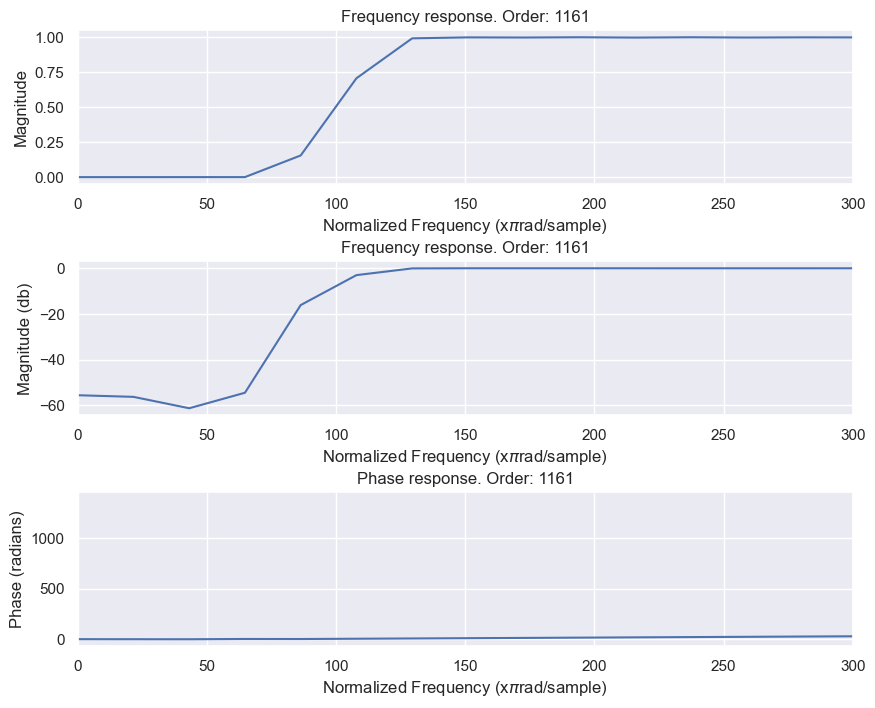

In [126]:
"Respuesta en frecuencia del filtro pasa altas"
mfreqz(bh,1, orden1+1,fNyquist,300)


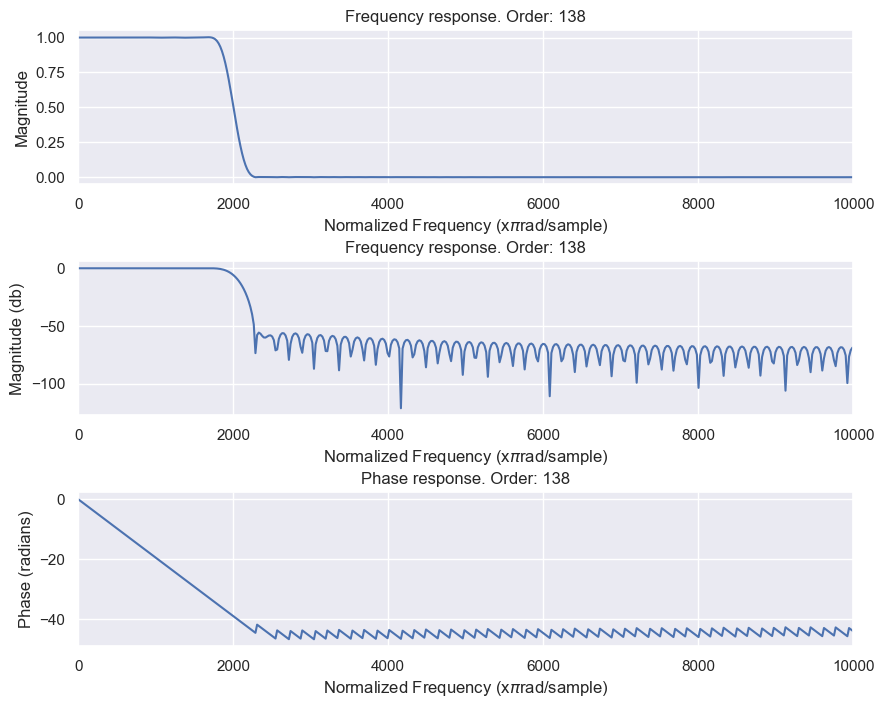

In [122]:
"Respuesta en frecuencia del filtro pasa bajas"
mfreqz(bl,1,orden2 +1,fNyquist)

In [129]:
def Filtro_FIR(senal,srate):
  """Funcion que se le ingresa la señal y la frecuencia de muestreo y retorna los coeficientes para 
     los dos filtros FIR , por medio de un pasabajas que no deje pasar frecuencias mayores a 2000 Hz 
     y un pasaltas que no deje pasar frecuencias menores a 100 Hz, esto con el fin de solo 
     dejar las frecuencias asociadas al sonido pulmonar"""
  fNyquist = srate/2; 
  f1=100 #Frecuencia de corte del filtro pasa altas
  f2=2000 # Frecuencia de corte del filtro pasa-bajas
  
  bandalp=(f2-f1)*0.1
  bandahp=f2*0.2

  #Frecuencia normalizada
  fn1=f1/fNyquist 
  fn2=f2/fNyquist

  #El orden debe ser par
  orden1=int(5*(fNyquist/bandalp))*4
  orden2=int(5*(fNyquist/bandahp))

  #Se ingresa el orden del filtro mas 1
  bh=signal.firwin(numtaps=orden1+1,cutoff=f1,pass_zero="highpass",fs=srate, window='hamming') #Coeficientes del filtro pasa altas
  bl=signal.firwin(numtaps=orden2+1, cutoff=f2,pass_zero="lowpass",fs=srate,window='hamming') #Coeficientes del filtro pasa bajas

  #filtrado
  pasaaltas = signal.filtfilt(bh, 1, senal)
  pasabanda = signal.filtfilt(bl, 1, pasaaltas)


  return np.asfortranarray(pasabanda)

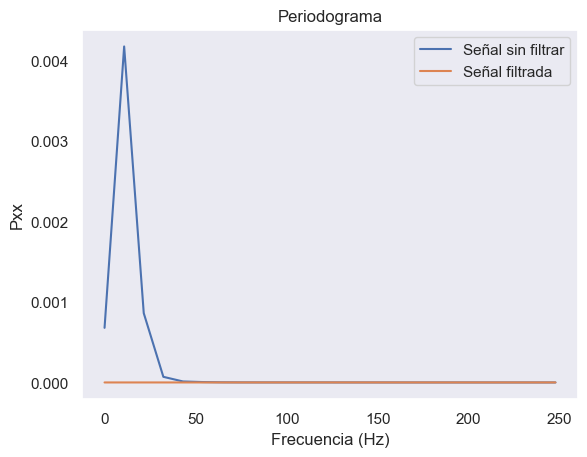

In [130]:
data,fs= librosa.load(base+'103_2b2_Ar_mc_LittC2SE.wav')
dt_FIR=Filtro_FIR(data,fs)

f_filter,pxx_filter=signal.welch( data,fs, 'hamming',2048,1024, scaling='density')
f_unfiltered,pxx_unfiltered=signal.welch( dt_FIR,fs, 'hamming',2048,1024, scaling='density')

plt.plot(f_filter[f_filter<250],pxx_filter[f_filter<250])
plt.plot(f_unfiltered[f_unfiltered<250],pxx_unfiltered[f_unfiltered<250])

max_value=np.max(np.concatenate((pxx_filter[f_filter>250],pxx_unfiltered[f_unfiltered>250])))
plt.grid()
plt.title('Periodograma')
plt.xlabel('Frecuencia (Hz)')
#plt.vlines(200, 0, max_value, color='black', linestyles='dashed')
plt.legend(['Señal sin filtrar', 'Señal filtrada'])
plt.ylabel('Pxx')
plt.show()

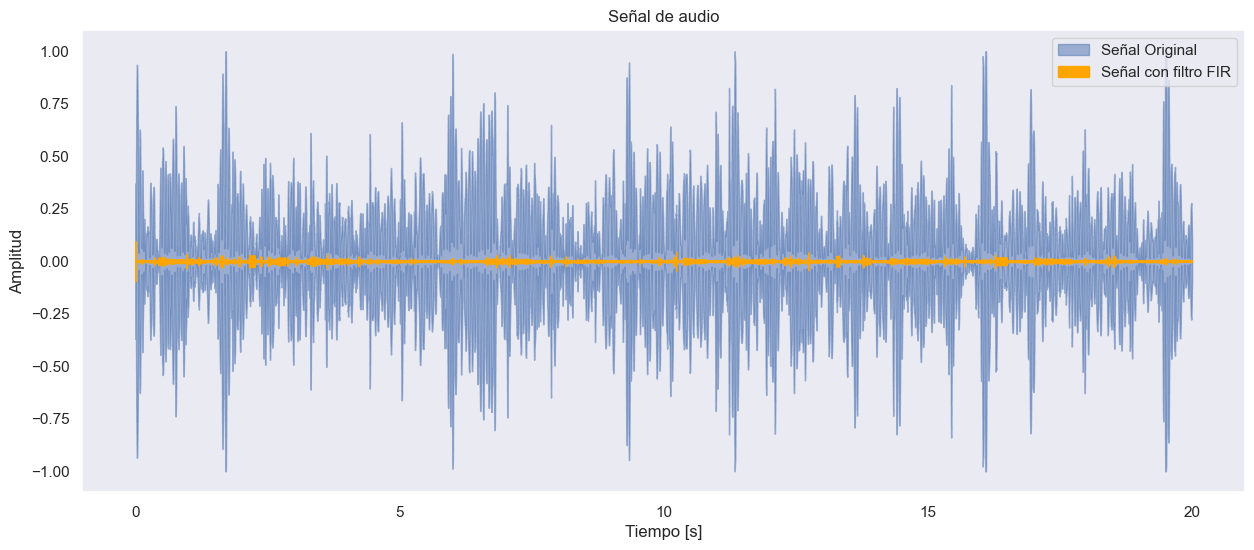

In [131]:
data,fs= librosa.load(base+'103_2b2_Ar_mc_LittC2SE.wav')
dt_FIR=Filtro_FIR(data,fs)

plt.figure(figsize=(15,6))
librosa.display.waveshow(data,sr=fs,alpha=0.5,label='Señal Original')
librosa.display.waveshow(dt_FIR,sr=fs,alpha=1, color='orange',label='Señal con filtro FIR')
plt.title('Señal de audio')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

### 3.  Adaptar el código entregado en clase para construir un filtro wavelet para eliminar los ruidos cardiacos

In [132]:
#Para estimar el ruido de los coeficientes de onda
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc; #Retorna estimaciones de la desviación estándar de los coeficientes de detalle para los niveles contenidos

# Tipo de aplicación del umbral de la limpieza wavelet
def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

#Tipo umbral soft o hard 
def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    # print(s)
    thr = threshold(coeff)
    # print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])));
    return thr,s,y;

In [133]:
def waveletFilter(y_bp):
    '''Funcion que se le ingresa la señal que se desea filtrar y se retorna la señal filtrado por medio de Daubechies6
       con el fin de reducir los ruidos producidos por el corazon en las señales de auscultaciones'''
    #LL = int(np.floor(np.log2(y_bp.shape[0]))); # Nivel de descomposición

    data_wavelet = pywt.wavedec( y_bp, 'db6', level=8 );
    details = data_wavelet[1:];

    thr, s, details_t = wthresh(details); #Son los coeficientes que me retorna la función de tipo umbral definida anteriormente 
    coeff = [];
    coeff.append(data_wavelet[0])

    for i in range(len(details_t)):
        coeff.append(details_t[i]);

    señal_reconstruida = pywt.waverec( coeff, 'db6');
    señal_reconstruida = señal_reconstruida[0:y_bp.shape[0]];
    
    señal_filtrada = np.squeeze(y_bp-señal_reconstruida)
    return señal_filtrada


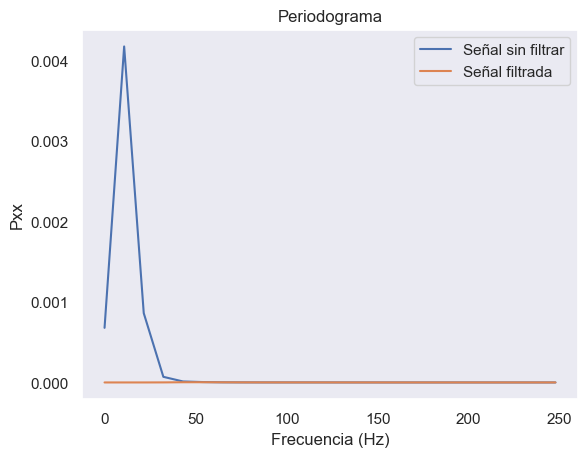

In [134]:
data2,fs2= librosa.load(base+'103_2b2_Ar_mc_LittC2SE.wav')
dt_FIR=waveletFilter(data2)

f_filter,pxx_filter=signal.welch( data2,fs2, 'hamming',2048,1024, scaling='density')
f_unfiltered,pxx_unfiltered=signal.welch( dt_FIR,fs2, 'hamming',2048,1024, scaling='density')

plt.plot(f_filter[f_filter<250],pxx_filter[f_filter<250])
plt.plot(f_unfiltered[f_unfiltered<250],pxx_unfiltered[f_unfiltered<250])

max_value=np.max(np.concatenate((pxx_filter[f_filter>250],pxx_unfiltered[f_unfiltered>250])))
plt.grid()
plt.title('Periodograma')
plt.xlabel('Frecuencia (Hz)')
#plt.vlines(200, 0, max_value, color='black', linestyles='dashed')
plt.legend(['Señal sin filtrar', 'Señal filtrada'])
plt.ylabel('Pxx')
plt.show()

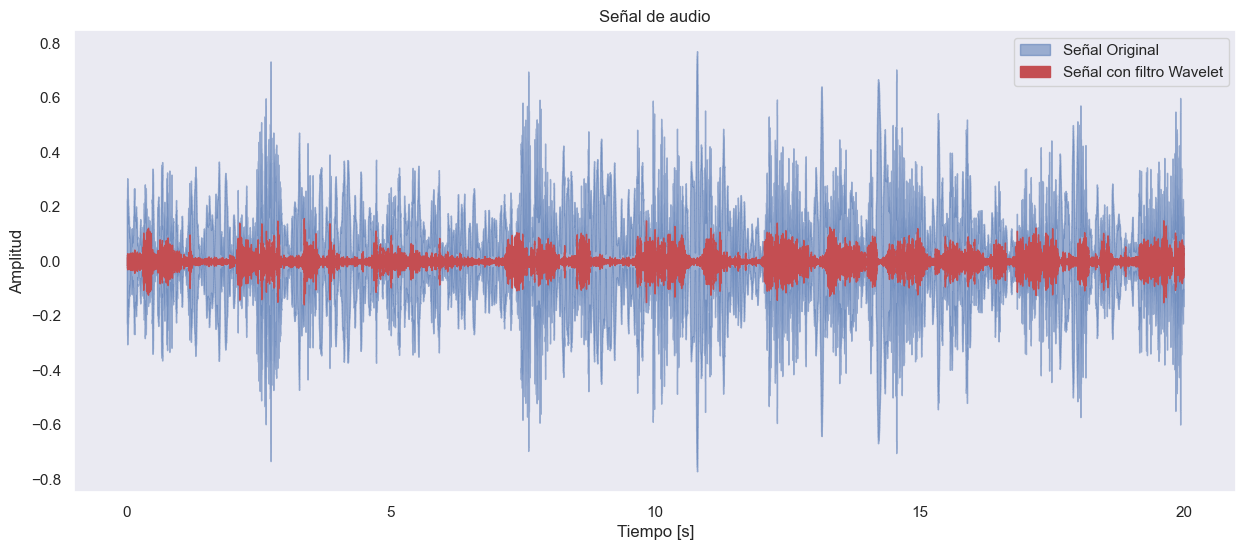

In [135]:
data,fs= librosa.load(archivos_wav[12])
dt_wav=waveletFilter(data)

plt.figure(figsize=(15,6))
librosa.display.waveshow(data,sr=fs,alpha=0.5,label='Señal Original')
librosa.display.waveshow(dt_wav,sr=fs, color='r',label='Señal con filtro Wavelet')
plt.title('Señal de audio')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()


### 4.   Crear una función que permita el preprocesamiento de la señal usando los filtros previos

In [136]:
def signalPreprocessing(signal,sr):

    dt_FIR=Filtro_FIR(signal,sr)
    dt_wav=waveletFilter(dt_FIR)
    return dt_wav

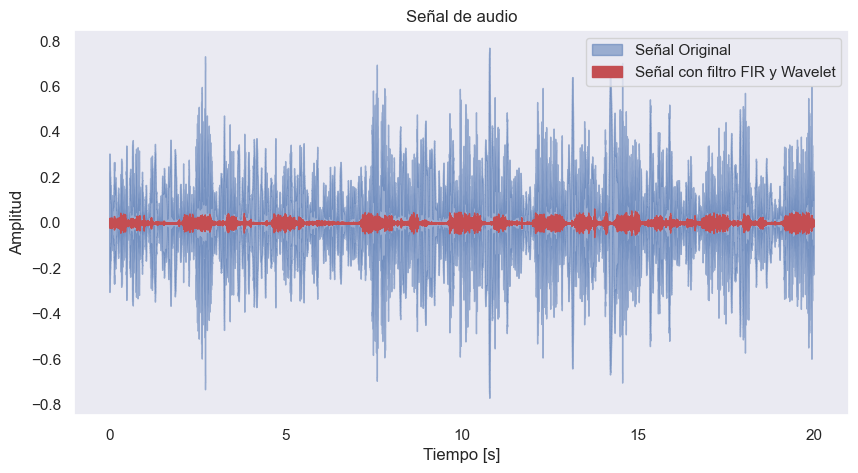

In [137]:
data_prep=signalPreprocessing(data,fs)

plt.figure(figsize=(10,5))
librosa.display.waveshow(data,sr=fs,alpha=0.5,label='Señal Original')
librosa.display.waveshow(data_prep,sr=fs, color='r',label='Señal con filtro FIR y Wavelet')

plt.title('Señal de audio')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.show()

### 5. Aplicar el preprocesamiento sobre todas las señales de la base de datos

In [138]:
normal=[]
sibilancias=[]
crepitancias=[]
for audio,text in zip(archivos_wav,archivos_txt):
    data,sr=librosa.load(audio)
    preprocess=signalPreprocessing(data,sr=sr)
    ciclos,df=xtractCicles(preprocess,text,sr=sr,type='file')
    ester=[ciclo for i, ciclo in enumerate(ciclos) if (df['Estertores'][i] == 1 and df['Sibilancias'][i] == 0)]
    sibi=[ciclo for i, ciclo in enumerate(ciclos) if (df['Sibilancias'][i] == 1 and df['Estertores'][i] == 0)]
    norm=[ciclo for i, ciclo in enumerate(ciclos) if (df['Estertores'][i] == 0 and df['Sibilancias'][i] == 0)]
    both=[ciclo for i, ciclo in enumerate(ciclos) if (df['Estertores'][i] == 1 and df['Sibilancias'][i] == 1)]
    normal+=norm
    sibilancias+=sibi
    crepitancias+=ester
    sibilancias+=both
    crepitancias+=both



In [139]:
normal[0].shape

(40000,)

In [140]:
len(normal),len(sibilancias),len(crepitancias)

(2646, 1122, 2084)

In [141]:
varianzas=[]
for i in sibilancias:
    varianzas.append(np.var(i))
len(varianzas)

1122

## Procesamiento y extracción de caracteristicas de la señal

### 6. En un gráfico comparar la densidad espectral de potencia para la señal de todos los ciclos normales, ciclos con sibilancias y ciclos con crepitancias, e identificar si existe un rango de frecuencias donde se maximice la diferencia entre las tres poblaciones.  

In [142]:
f_n=[]
f_s=[]
f_e=[]
px_n=[]
px_s=[]
px_c=[]

#Se halla el PSD para ciclos normales
for i in range(0,len(normal)):
  #Estimación de la densidad espectral con una ventana tipo hamming. 
  fn, Pn = signal.welch( normal[i], 22050, 'hamming',2000,1000, scaling='density')
  px_n.append(Pn)
  f_n.append(fn)

#PSD para ciclos sibilantes.
for i in range(0,len(sibilancias)):
  #Estimación de la densidad espectral con una ventana tipo hamming. 
  fs, Ps = signal.welch( sibilancias[i],22050, 'hamming',2000,1000, scaling='density')
  px_s.append(Ps)
  f_s.append(fs)

#PSD para ciclos crepitantes. 
for i in range(0,len(crepitancias)):
  #Estimación de la densidad espectral con una ventana tipo hamming.  
  fc, Pc = signal.welch( crepitancias[i],22050, 'hamming',2000, 1000,scaling='density')
  px_c.append(Pc)
  f_e.append(fc)

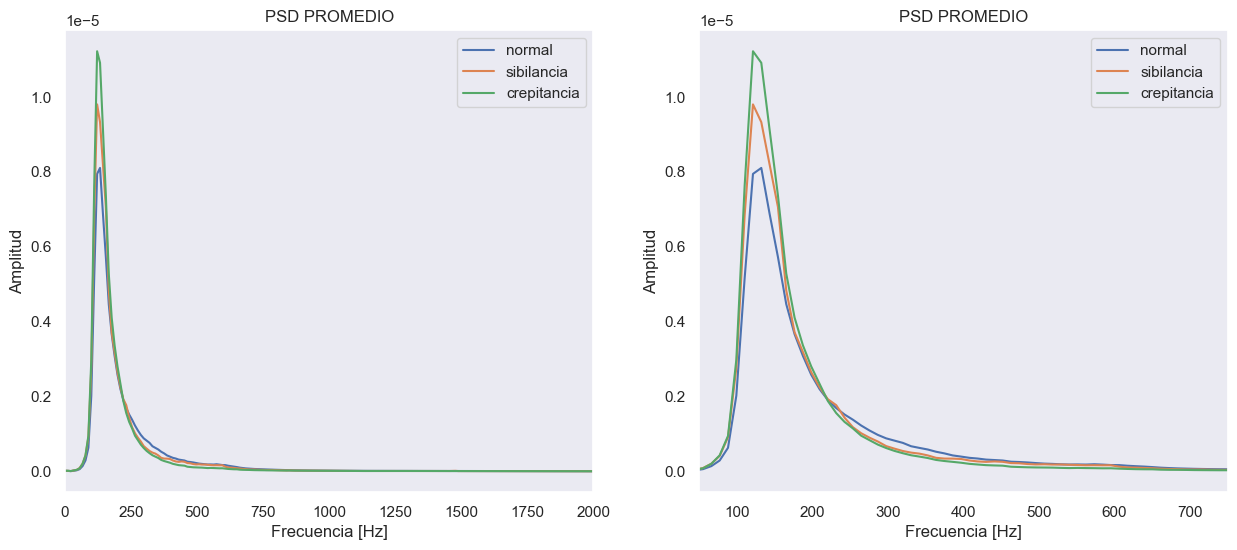

In [143]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_s[0], np.mean(px_s,axis=0), label='sibilancia')
plt.plot(f_e[0], np.mean(px_c,axis=0), label='crepitancia')

plt.xlim(0,2000)

#Se grafican el promedio de los ciclos en una sola gráfica.
plt.title('PSD PROMEDIO')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()


plt.subplot(122)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_s[0], np.mean(px_s,axis=0), label='sibilancia')
plt.plot(f_e[0], np.mean(px_c,axis=0), label='crepitancia')

#Se grafican el promedio de los ciclos en una sola gráfica.
plt.xlim(50,750)
plt.title('PSD PROMEDIO')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

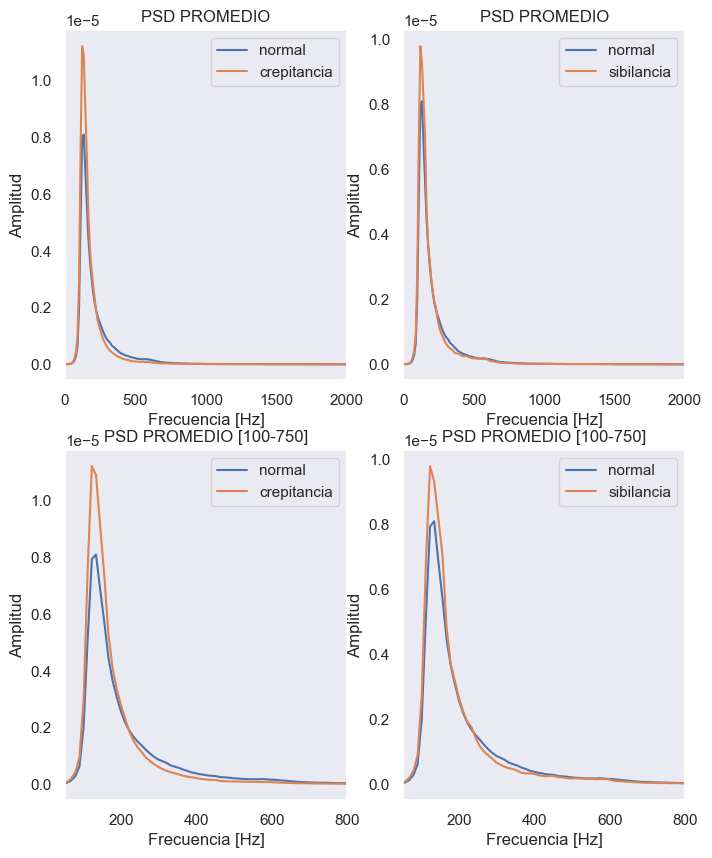

In [191]:
plt.figure(figsize=(8,10))
plt.subplot(221)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_e[0], np.mean(px_c,axis=0), label='crepitancia')

plt.xlim(0,2000)

#Se grafican el promedio de los ciclos en una sola gráfica.
plt.title('PSD PROMEDIO')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()


plt.subplot(222)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_s[0], np.mean(px_s,axis=0), label='sibilancia')

#Se grafican el promedio de los ciclos en una sola gráfica.
plt.xlim(0,2000)
plt.title('PSD PROMEDIO')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()


plt.subplot(223)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_e[0], np.mean(px_c,axis=0), label='crepitancia')
plt.xlim(50,800)
plt.title('PSD PROMEDIO [100-750]')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()


plt.subplot(224)
plt.plot(f_n[0], np.mean(px_n,axis=0), label='normal')
plt.plot(f_s[0], np.mean(px_s,axis=0), label='sibilancia')
plt.xlim(50,800)
plt.title('PSD PROMEDIO [100-750]')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.show()

In [145]:
len(f_n[0])

1001

### 7. Crear una rutina que permita extraer la sumatoria de la densidad espectral de potencia en el rango identificado en el punto 6

In [146]:
def rango_frec(ciclo, fmin, fmax):
    f, Pxx = signal.welch( ciclo,22050, 'hamming',2000,1000, scaling='density')
    Pxx = Pxx[(f > fmin) & (f <= fmax)]
    return Pxx

In [192]:
sumatoria_PSD=[]
for sibilancia in sibilancias:
    suma=rango_frec(sibilancia, 100,750)
    sumatoria_PSD.append(np.sum(suma))


In [148]:
sumatoria_PSD

[1.0129804380943096e-06,
 1.0082319135792375e-06,
 1.10265979318493e-06,
 9.762497560558726e-07,
 1.234790711784349e-06,
 1.838015587897706e-06,
 1.4911582409844883e-06,
 1.1881930979291818e-06,
 1.2880834700407075e-06,
 9.792646982878207e-07,
 1.386859612774177e-06,
 1.7849848857644063e-06,
 6.190459479424962e-06,
 1.0755188857522926e-05,
 1.2788344151634044e-05,
 1.4446689664746222e-05,
 1.5516861751846424e-05,
 1.297606669221248e-05,
 1.0795554972648194e-05,
 0.00017646177540617838,
 0.00021243730191874516,
 0.00017633506781105016,
 0.00022295259742868771,
 0.0002134696704354999,
 0.0005959418005927091,
 0.0007346311813223451,
 0.000138486114521991,
 0.00013681628960375932,
 3.794605895372309e-05,
 4.0570504973407734e-05,
 5.157237976870204e-05,
 3.646963477174009e-05,
 3.054464780316229e-05,
 3.55731935769235e-05,
 2.941799490319239e-05,
 2.9370939030761472e-05,
 2.6374779152964954e-05,
 3.890572450285519e-05,
 4.15153482910069e-05,
 4.097575426841137e-05,
 1.9507909180835535e-05,


### 8.  Crear una rutina que permita extraer la mediana de la densidad espectral de potencia, en el dominio de la frecuencia, de cada registro como un índice de comparación 
a. La mediana es el valor de potencia debajo del cual se encuentra la mitad de potencia 
de un registro

### 9. Crear una rutina que permita extraer la varianza de la señal, en el dominio del tiempo, de cada registro

### 10.  Crear una rutina que aplique sobre todos los archivos de la base de datos las rutinas de preprocesamiento y extracción de todas las características discutidas y guarde la información en un dataframe donde se pueda discriminar información relacionada con ciclos normales, ciclos con crepitaciones y ciclos con sibilancias

In [233]:
sumatoria_PSD=[]
mediana_PSD=[]
varianza_T=[]
estado=[]
for norm in normal:
    rango=rango_frec(norm, 100,750)
    sumatoria_PSD.append(np.sum(rango))
    mediana= np.mean(rango)
    mediana_PSD.append(mediana)
    varianza= np.var(norm)
    varianza_T.append(varianza)
    estado.append('Ciclo normal')
    
for sibilancia in sibilancias:
    rango=rango_frec(sibilancia, 100,750)
    sumatoria_PSD.append(np.sum(rango))
    mediana= np.mean(rango)
    mediana_PSD.append(mediana)
    varianza= np.var(sibilancia)
    varianza_T.append(varianza)
    estado.append('Ciclo con Sibilancia')

for crepitancia in crepitancias:
    rango=rango_frec(crepitancia, 100,750)
    sumatoria_PSD.append(np.sum(rango))
    mediana= np.mean(rango)
    mediana_PSD.append(mediana)
    varianza= np.var(crepitancia)
    varianza_T.append(varianza)
    estado.append('Ciclo con Crepitancia')




In [234]:
Dataframe={}
Dataframe['Sumatoria PSD']= sumatoria_PSD
Dataframe['Mediana PSD']= mediana_PSD
Dataframe['Varianza']=varianza_T
Dataframe['Estado del ciclo']=estado

In [235]:
Datos=pd.DataFrame(Dataframe)
Datos.head(5),Datos.tail(5),Datos[3000:3005]

(   Sumatoria PSD   Mediana PSD  Varianza Estado del ciclo
 0   4.553394e-07  7.717617e-09  0.000006     Ciclo normal
 1   4.341314e-07  7.358159e-09  0.000006     Ciclo normal
 2   3.933731e-07  6.667341e-09  0.000005     Ciclo normal
 3   4.331865e-07  7.342145e-09  0.000006     Ciclo normal
 4   3.739470e-07  6.338084e-09  0.000005     Ciclo normal,
       Sumatoria PSD   Mediana PSD  Varianza       Estado del ciclo
 5847   1.211710e-06  2.053747e-08  0.000014  Ciclo con Crepitancia
 5848   4.454285e-07  7.549636e-09  0.000006  Ciclo con Crepitancia
 5849   4.599597e-07  7.795926e-09  0.000005  Ciclo con Crepitancia
 5850   4.904323e-07  8.312412e-09  0.000006  Ciclo con Crepitancia
 5851   5.699087e-07  9.659469e-09  0.000007  Ciclo con Crepitancia,
       Sumatoria PSD   Mediana PSD  Varianza      Estado del ciclo
 3000       0.000036  6.125745e-07  0.000413  Ciclo con Sibilancia
 3001       0.000032  5.453533e-07  0.000379  Ciclo con Sibilancia
 3002       0.000025  4.184147e-07 

In [236]:
Datos.to_csv("TabladeResultados.csv",index=False) # Se exporta el dataframe como un archivo.csv para trabajar con mayor facilidad

## ESTADÍSTICA


In [237]:
df= pd.read_csv("TabladeResultados.csv") #Se importa el archivo con los datos
print(df.head(),df.info()) # Se corrobora la información 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sumatoria PSD     5852 non-null   float64
 1   Mediana PSD       5852 non-null   float64
 2   Varianza          5852 non-null   float64
 3   Estado del ciclo  5852 non-null   object 
dtypes: float64(3), object(1)
memory usage: 183.0+ KB
   Sumatoria PSD   Mediana PSD  Varianza Estado del ciclo
0   4.553394e-07  7.717617e-09  0.000006     Ciclo normal
1   4.341314e-07  7.358159e-09  0.000006     Ciclo normal
2   3.933731e-07  6.667341e-09  0.000005     Ciclo normal
3   4.331865e-07  7.342145e-09  0.000006     Ciclo normal
4   3.739470e-07  6.338084e-09  0.000005     Ciclo normal None


In [238]:
df.describe()

,Sumatoria PSD,Mediana PSD,Varianza
count,5.852000e+03,5.852000e+03,5.852000e+03
mean,7.492886e-05,1.269981e-06,8.742001e-04
std,1.594532e-04,2.702597e-06,1.836884e-03
min,6.479957e-09,1.098298e-10,7.424936e-08
25%,2.006724e-06,3.401227e-08,2.421252e-05
50%,1.304478e-05,2.210980e-07,1.598180e-04
75%,6.961261e-05,1.179875e-06,8.174248e-04
max,1.902935e-03,3.225314e-05,2.175454e-02


In [239]:
df_estado=df['Estado del ciclo']
df_estado

0                Ciclo normal
1                Ciclo normal
2                Ciclo normal
3                Ciclo normal
4                Ciclo normal
                ...          
5847    Ciclo con Crepitancia
5848    Ciclo con Crepitancia
5849    Ciclo con Crepitancia
5850    Ciclo con Crepitancia
5851    Ciclo con Crepitancia
Name: Estado del ciclo, Length: 5852, dtype: object

In [240]:
df_NORMAL=df[df['Estado del ciclo'] == 'Ciclo normal'] # Se definen los ciclos normales
df_SIBILANCIA = df[df['Estado del ciclo'] == 'Ciclo con Sibilancia'] # Se definen los ciclos con sibilancia
df_CREPITANCIA = df[df['Estado del ciclo'] == 'Ciclo con Crepitancia'] # Se definen los ciclos con crepitancia


In [241]:
df_NORMAL.describe()

,Sumatoria PSD,Mediana PSD,Varianza
count,2.646000e+03,2.646000e+03,2.646000e+03
mean,7.121632e-05,1.207056e-06,8.250170e-04
std,1.769509e-04,2.999167e-06,2.023055e-03
min,6.479957e-09,1.098298e-10,7.424936e-08
25%,1.032914e-06,1.750702e-08,1.252227e-05
50%,6.384180e-06,1.082064e-07,7.616431e-05
75%,5.436221e-05,9.213934e-07,6.474908e-04
max,1.902935e-03,3.225314e-05,2.175454e-02


In [242]:
df_SIBILANCIA.describe()

,Sumatoria PSD,Mediana PSD,Varianza
count,1.122000e+03,1.122000e+03,1.122000e+03
mean,7.601297e-05,1.288355e-06,8.958889e-04
std,1.518771e-04,2.574188e-06,1.775401e-03
min,8.540225e-09,1.447496e-10,1.022550e-07
25%,2.404374e-06,4.075211e-08,2.909556e-05
50%,1.423730e-05,2.413101e-07,1.696005e-04
75%,8.149342e-05,1.381244e-06,9.547584e-04
max,1.425185e-03,2.415568e-05,1.633738e-02


In [243]:
df_CREPITANCIA.describe()

,Sumatoria PSD,Mediana PSD,Varianza
count,2.084000e+03,2.084000e+03,2.084000e+03
mean,7.905891e-05,1.339982e-06,9.249695e-04
std,1.385984e-04,2.349125e-06,1.605773e-03
min,1.054858e-08,1.787894e-10,1.250334e-07
25%,4.530174e-06,7.678260e-08,5.539306e-05
50%,2.654395e-05,4.498974e-07,3.102536e-04
75%,8.882269e-05,1.505469e-06,1.055020e-03
max,1.111768e-03,1.884353e-05,1.283135e-02


In [244]:
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind

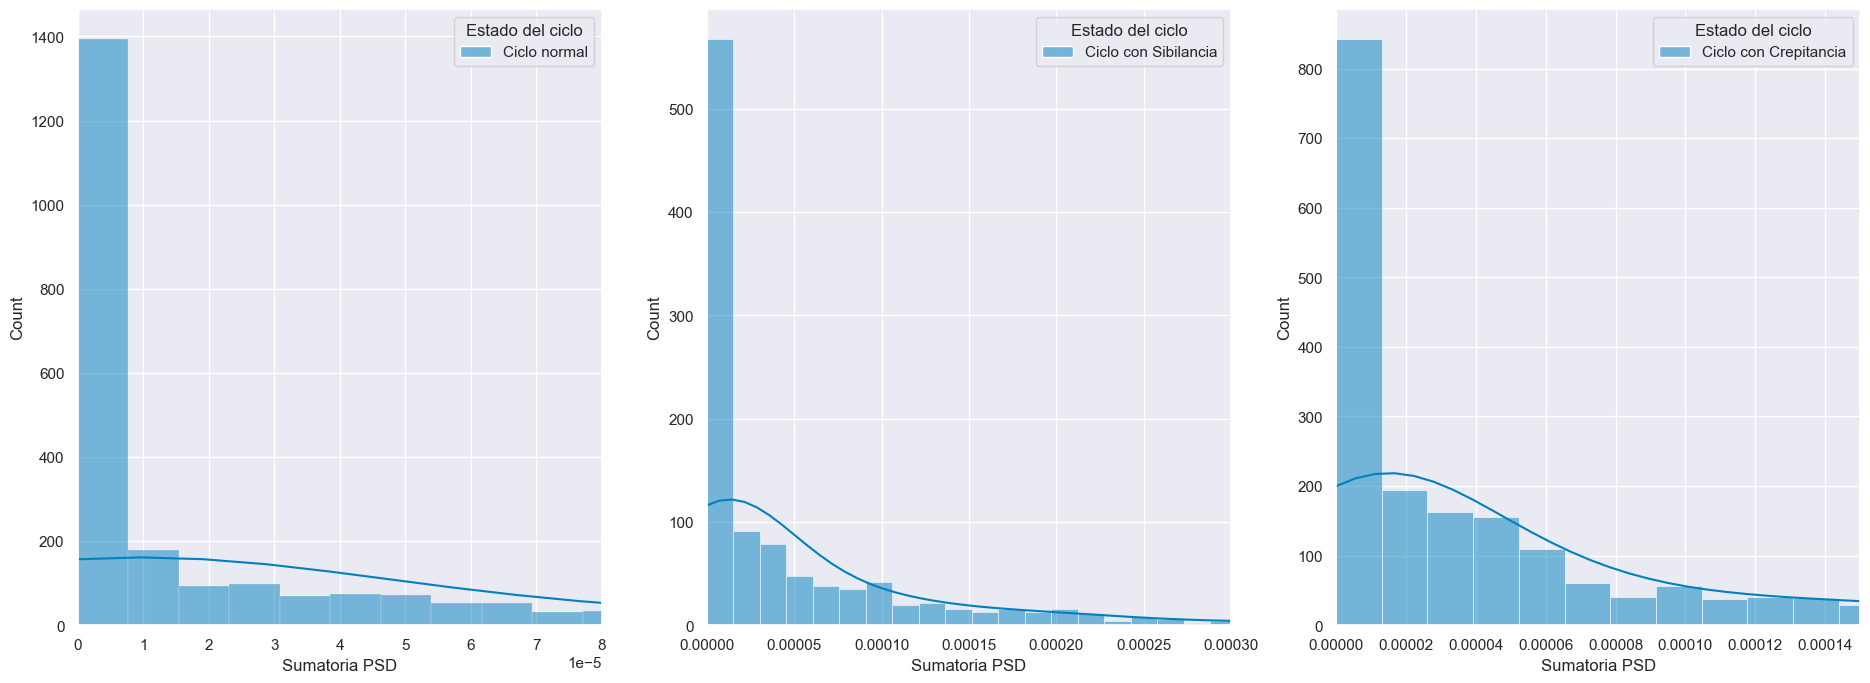

In [245]:
#Histograma de los diferentes ciclos respiratorios
plt.figure(figsize = (23, 8))
sns.set_theme(style = "darkgrid")
plt.subplot(1,3,1)
sns.histplot(data=df_NORMAL, x = "Sumatoria PSD",hue ="Estado del ciclo",kde = True,palette="winter")
plt.xlim([0,8e-5])
plt.subplot(1,3,2)
sns.histplot(data=df_SIBILANCIA, x = "Sumatoria PSD",hue ="Estado del ciclo",kde = True,palette="winter")
plt.xlim([0,3e-4])
plt.subplot(1,3,3)
sns.histplot(data=df_CREPITANCIA, x = "Sumatoria PSD",hue ="Estado del ciclo",kde = True,palette="winter")
plt.xlim([0,15e-5])
plt.show()

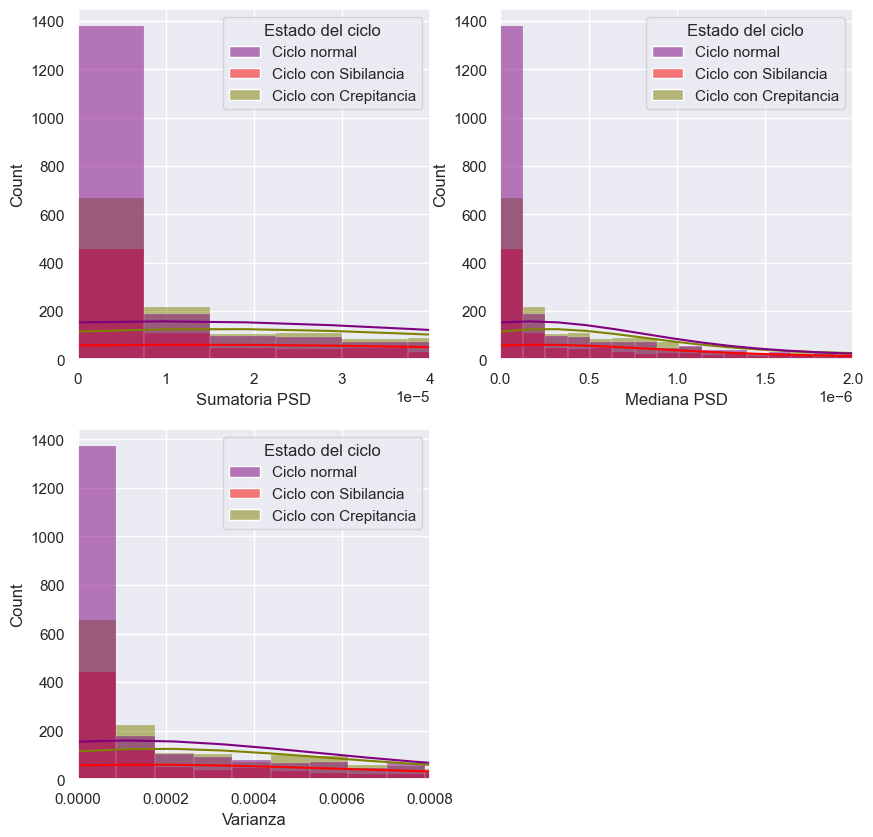

In [246]:
plt.figure(figsize = (10,10))
sns.set_theme(style = "darkgrid")
plt.subplot(2,2,1)
sns.histplot(data=df, x = "Sumatoria PSD",hue ="Estado del ciclo",kde = True,palette="brg")
plt.xlim([0,0.4e-4])
plt.subplot(2,2,2)
sns.histplot(data=df, x = "Mediana PSD",hue ="Estado del ciclo",kde = True,palette="brg")
plt.xlim([0,0.2e-5])
plt.subplot(2,2,3)
sns.histplot(data=df, x = "Varianza",hue ="Estado del ciclo",kde = True,palette="brg")
plt.xlim([0,0.08e-2])
plt.show()

In [247]:
def caja_bigotes(df1,df2,df3,stat):
    labels=['NORMAL','SIBILANCIA','CREPITANCIA']
    
    plt.boxplot([df1[stat], df2[stat], df3[stat]], labels=labels)
    plt.title(stat)
    plt.show()

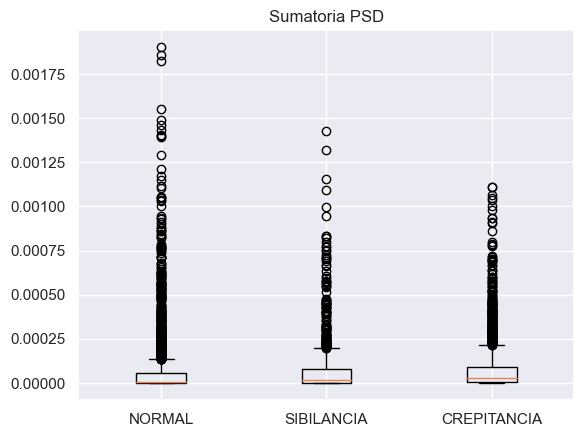

In [248]:
caja_bigotes(df_NORMAL,df_SIBILANCIA,df_CREPITANCIA, 'Sumatoria PSD')

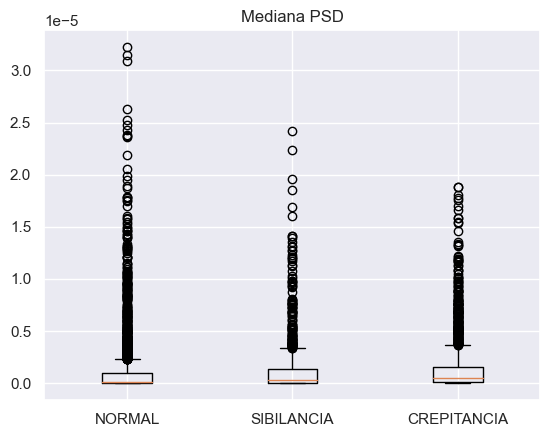

In [249]:
caja_bigotes(df_NORMAL,df_SIBILANCIA,df_CREPITANCIA, 'Mediana PSD')

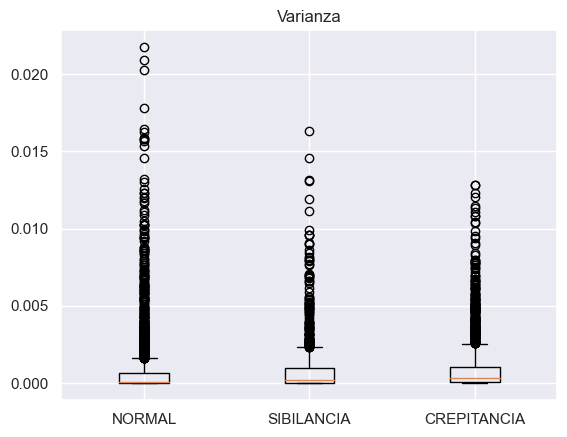

In [250]:
caja_bigotes(df_NORMAL,df_SIBILANCIA,df_CREPITANCIA, 'Varianza')

In [251]:
def Prueba_Normalidad(data):
  """
  Si el valor p ≤ 0,05, rechazamos la hipótesis nula, es decir, asumimos que la distribución de nuestra variable no es normal/gaussiana.
  Si el valor p > 0,05, entonces no rechazamos la hipótesis nula, es decir, asumimos que la distribución de nuestra variable es normal/gaussiana.
  """
  #for columna in data.columns[0:-1]:
  stat,p=stats.normaltest(data)
  if p>0.05:
      a="Probably Gaussian"
  else:
      a="Probably not Gaussian"
  print('Stat', stat)
  print('p', p)

  return a

In [252]:
Prueba_Normalidad(df_NORMAL['Sumatoria PSD']),Prueba_Normalidad(df_SIBILANCIA['Sumatoria PSD']),Prueba_Normalidad(df_CREPITANCIA['Sumatoria PSD'])

Stat 2571.46955554284
p 0.0
Stat 953.2319558078653
p 1.0193206192638917e-207
Stat 1525.9601764402703
p 0.0


('Probably not Gaussian', 'Probably not Gaussian', 'Probably not Gaussian')

In [253]:
def realizar_prueba_t(df1, df2):
    for columna in df1.columns[0:-1]:
        t_statistic, p_value = ttest_ind(df1[columna], df2[columna])
        print(f"Característica: {columna}")
        print(f"Valor p: {p_value}")
        if p_value < 0.05:
            print("Hay una diferencia significativa entre las categorías.\n")
        else:
            print("No hay una diferencia significativa entre las categorías.\n")


In [254]:
df_NORMAL.columns[0:-1]

Index(['Sumatoria PSD', 'Mediana PSD', 'Varianza'], dtype='object')

In [255]:
realizar_prueba_t(df_NORMAL,df_SIBILANCIA)

Característica: Sumatoria PSD
Valor p: 0.42807004824963757
No hay una diferencia significativa entre las categorías.

Característica: Mediana PSD
Valor p: 0.42807004824946426
No hay una diferencia significativa entre las categorías.

Característica: Varianza
Valor p: 0.30836099293191255
No hay una diferencia significativa entre las categorías.



Dado que el valor de p es menor a 0.05, podemos rechazar la hipótesis nula de que no hay diferencia entre las dos categorías en términos de la sumatoria de la PSD. Por lo tanto, podemos concluir que existe una diferencia significativa en la distribución de la potencia en el dominio de la frecuencia entre los ciclos con sibilancias y los ciclos normales.

In [256]:
realizar_prueba_t(df_NORMAL,df_CREPITANCIA)

Característica: Sumatoria PSD
Valor p: 0.09671458030451728
No hay una diferencia significativa entre las categorías.

Característica: Mediana PSD
Valor p: 0.09671458030440423
No hay una diferencia significativa entre las categorías.

Característica: Varianza
Valor p: 0.06526069325588632
No hay una diferencia significativa entre las categorías.



TRANSFORMACIONES DE POTENCIA

In [257]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [258]:
df_to_transform=df[df.columns[0:-1]]
df_to_transform

,Sumatoria PSD,Mediana PSD,Varianza
0,4.553394e-07,7.717617e-09,0.000006
1,4.341314e-07,7.358159e-09,0.000006
2,3.933731e-07,6.667341e-09,0.000005
3,4.331865e-07,7.342145e-09,0.000006
4,3.739470e-07,6.338084e-09,0.000005
...,...,...,...
5847,1.211710e-06,2.053747e-08,0.000014
5848,4.454285e-07,7.549636e-09,0.000006
5849,4.599597e-07,7.795926e-09,0.000005
5850,4.904323e-07,8.312412e-09,0.000006


In [259]:
import pandas as pd
from scipy import stats

def boxcox_transform(df):
    # Aplicar la función boxcox a cada columna del DataFrame
    df_transformed = df.apply(lambda x: stats.boxcox(x)[0])

    return df_transformed

In [260]:
'Dataframe entero con la transformación de potencia hecha'
df_boxcox=boxcox_transform(df_to_transform)
df_boxcox['Estado del ciclo']= df_estado
df_boxcox

,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
0,-9.018249,-10.246727,-7.953967,Ciclo normal
1,-9.034812,-10.259061,-7.938586,Ciclo normal
2,-9.068869,-10.284421,-7.964129,Ciclo normal
3,-9.035568,-10.259623,-7.946835,Ciclo normal
4,-9.086270,-10.297378,-8.008961,Ciclo normal
...,...,...,...,...
5847,-8.665429,-9.984003,-7.576096,Ciclo con Crepitancia
5848,-9.025898,-10.252423,-7.956139,Ciclo con Crepitancia
5849,-9.014735,-10.244111,-7.973094,Ciclo con Crepitancia
5850,-8.992352,-10.227443,-7.949450,Ciclo con Crepitancia


In [261]:
df_boxcox.to_csv("TabladeResultadosBoxCox.csv",index=False) # Se exporta el dataframe como un archivo.csv para trabajar con mayor facilidad

In [262]:
transform_N = df_boxcox[df_boxcox['Estado del ciclo'] == 'Ciclo normal'] # Se definen los ciclos normales
transform_S = df_boxcox[df_boxcox['Estado del ciclo'] == 'Ciclo con Sibilancia'] # Se definen los ciclos con sibilancia
transform_C = df_boxcox[df_boxcox['Estado del ciclo'] == 'Ciclo con Crepitancia'] # Se definen los ciclos con crepitancia

In [263]:
def caja_bigotes2(df1,df2,df3,stat):
    labels=['NORMAL','SIBILANCIA','CREPITANCIA']
    
    plt.boxplot([df1[stat], df2[stat], df3[stat]], labels=labels)
    plt.title(stat)
    plt.show()

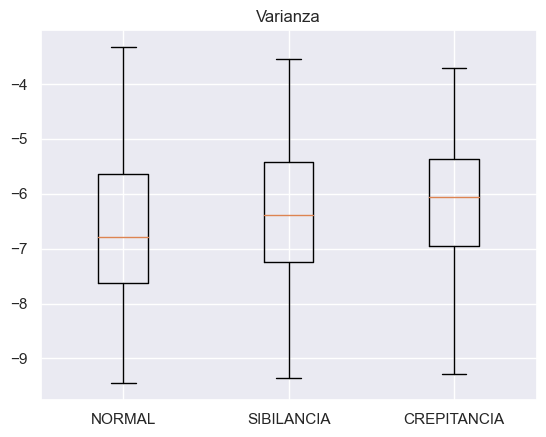

In [264]:
caja_bigotes2(transform_N,transform_S,transform_C, 'Varianza')

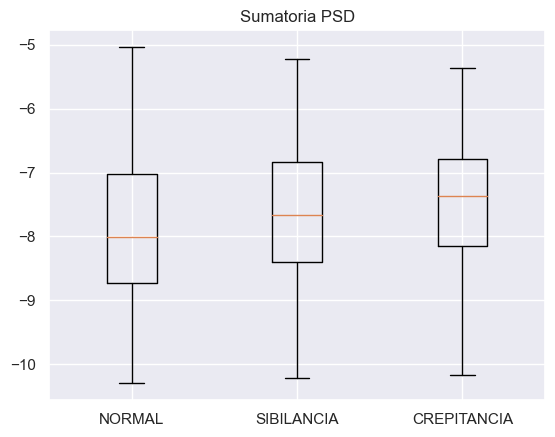

In [265]:
caja_bigotes2(transform_N,transform_S,transform_C, 'Sumatoria PSD')

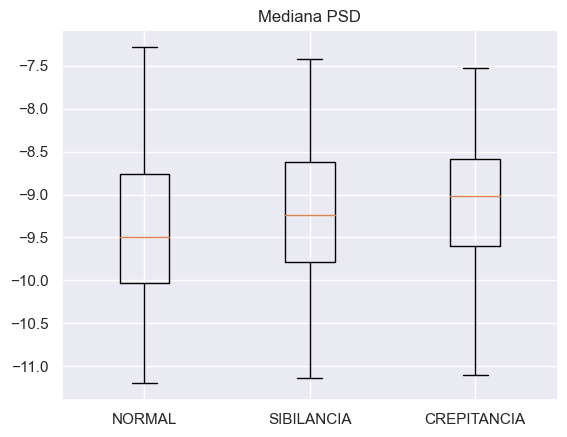

In [266]:
caja_bigotes2(transform_N,transform_S,transform_C, 'Mediana PSD')

In [267]:
transform_N

,Sumatoria PSD,Mediana PSD,Varianza,Estado del ciclo
0,-9.018249,-10.246727,-7.953967,Ciclo normal
1,-9.034812,-10.259061,-7.938586,Ciclo normal
2,-9.068869,-10.284421,-7.964129,Ciclo normal
3,-9.035568,-10.259623,-7.946835,Ciclo normal
4,-9.086270,-10.297378,-8.008961,Ciclo normal
...,...,...,...,...
2641,-9.067449,-10.283363,-8.003907,Ciclo normal
2642,-9.016100,-10.245127,-7.964570,Ciclo normal
2643,-9.025932,-10.252448,-7.945721,Ciclo normal
2644,-9.005063,-10.236909,-7.958905,Ciclo normal


In [268]:
Prueba_Normalidad(transform_N['Sumatoria PSD']),Prueba_Normalidad(transform_S['Sumatoria PSD']),Prueba_Normalidad(transform_C['Sumatoria PSD'])

Stat 197.49216095857295
p 1.3035333244895801e-43
Stat 72.16910029808741
p 2.1314688411889206e-16
Stat 54.022678874028585
p 1.8583364000247693e-12


('Probably not Gaussian', 'Probably not Gaussian', 'Probably not Gaussian')

In [269]:
def realizar_prueba_t2(df1, df2):
    for columna in df1.columns[0:-1]:
        t_statistic, p_value = ttest_ind(df1[columna], df2[columna])
        print(f"Característica: {columna}")
        print(f"Valor p: {p_value}")
        if p_value < 0.05:
            print("Hay una diferencia significativa entre las categorías.\n")
        else:
            print("No hay una diferencia significativa entre las categorías.\n")

In [270]:
realizar_prueba_t2(transform_N,transform_S)

Característica: Sumatoria PSD
Valor p: 1.9418155003043283e-10
Hay una diferencia significativa entre las categorías.

Característica: Mediana PSD
Valor p: 1.9418142504347032e-10
Hay una diferencia significativa entre las categorías.

Característica: Varianza
Valor p: 2.0400739950905006e-10
Hay una diferencia significativa entre las categorías.



In [271]:
realizar_prueba_t2(transform_N,transform_C)

Característica: Sumatoria PSD
Valor p: 3.6694663831384042e-37
Hay una diferencia significativa entre las categorías.

Característica: Mediana PSD
Valor p: 3.6694582554944733e-37
Hay una diferencia significativa entre las categorías.

Característica: Varianza
Valor p: 8.580476397290388e-37
Hay una diferencia significativa entre las categorías.



In [272]:
p_values={}
alpha_u = 0.05
for col in transform_N.columns:
    stat, p = mannwhitneyu(list(transform_N[col]), list(transform_C[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_u:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que son iguales estadisticamente')
df_cohe = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_cohe

Canal Sumatoria PSD: Estadístico U=2141948.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Sumatoria PSD de ambos grupos.

Canal Mediana PSD: Estadístico U=2141948.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Mediana PSD de ambos grupos.

Canal Varianza: Estadístico U=2144797.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Varianza de ambos grupos.



c:\Users\Esteban\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
p_values={}
alpha_u = 0.05
for col in transform_N.columns:
    stat, p = mannwhitneyu(list(transform_N[col]), list(transform_S[col]), alternative='two-sided')#Implementación de la prueba U de Mann-Whitney
    print(f'Canal {col}: Estadístico U={stat:.3f}, p={p:.3f}')
    if p > alpha_u:
        print(f'No se puede rechazar la hipótesis nula de que no existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
        p_values[col]=p
    else:
        print(f'Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal {col} de ambos grupos.\n')
print('--------------------------------------------------------------------------------------------')
print('Los siguientes canales corresponden a aquellos que son iguales estadisticamente')
df_cohe = pd.DataFrame.from_dict(p_values, orient='index', columns=['Valor P'])
df_cohe

Canal Sumatoria PSD: Estadístico U=789655.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Sumatoria PSD de ambos grupos.

Canal Mediana PSD: Estadístico U=789655.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Mediana PSD de ambos grupos.

Canal Varianza: Estadístico U=791853.000, p=0.000
Se rechaza la hipótesis nula de que existe diferencia estadística entre los datos del canal Varianza de ambos grupos.



TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''